# Linear Variational Method - Anharmonic Oscillator
Jay Foley, UNC Charlotte

# Run the next two cells before beginning!

In [1]:
# library imports for the entire notebook
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from numpy import trapz
from scipy.special import hermite
from math import factorial

# conversion factor from atomic units of energy to wavenumbers in inverse centimeters
au_to_wn = 219474.63068

In [2]:
def compute_alpha(k, mu):
    """ Helper function to compute \alpha = \sqrt{k * \omega / \hbar}

    Arguments
    ---------
    k : float
        the Harmonic force constant

    mu : float
        the reduced mass

    Returns
    -------
    alpha : float
        \alpha = \sqrt{k * \omega / \hbar}

    """
    # hbar
    hbar = 1.0
    # compute omega
    omega = np.sqrt( k / mu )

    # compute alpha
    alpha =  mu * omega / hbar

    # return alpha
    return alpha

def N(n, alpha):
    """ Helper function to take the quantum number n of the Harmonic Oscillator and return the normalization constant

    Arguments
    ---------
    n : int
        the quantum state of the harmonic oscillator

    Returns
    -------
    N_n : float
        the normalization constant
    """

    return  np.sqrt( 1 / (2 ** n * factorial(n)) ) * ( alpha / np.pi ) ** (1/4)

def psi(n, alpha, r, r_eq):
    """ Helper function to evaluate the Harmonic Oscillator energy eigenfunction for state n

    Arguments
    ---------
    n : int
        the quantum state of the harmonic oscillator

    alpha : float
        alpha value


    r : float
        position at which psi_n will be evaluated

    r_eq : float
        equilibrium bondlength

    Returns
    -------
    psi_n : float
        value of the harmonic oscillator energy eigenfunction

    """

    Hr = hermite(n)

    psi_n = N(n, alpha) * Hr( np.sqrt(alpha) * ( r - r_eq )) * np.exp( -0.5 * alpha  * (r - r_eq)**2)

    return psi_n

def harmonic_eigenvalue(n, k, mu):
    """ Helper function to evaluate the energy eigenvalue of the harmonic oscillator for state n"""
    hbar = 1.0
    return hbar * np.sqrt(k/mu) * (n + 1/2)


def potential_matrix_element(n, m, alpha, r, r_eq, V_p):
    """ Helper function to compute <n|V_p|m> where V_p is the perturbing potential

    Arguments
    ---------
    n : int
        quantum number of the bra state

    m : int
        quantum number of the ket state

    alpha : float
        alpha constant for bra/ket states

    r : float
        position grid for bra/ket states

    r_eq : float
        equilibrium bondlength for bra/ket states

    V_p : float
        potential array

    Returns
    -------
    V_nm : float
        <n | V_p | m >

    """
    # bra
    psi_n = psi(n, alpha, r, r_eq)

    # ket
    psi_m = psi(m, alpha, r, r_eq)

    # integrand
    integrand = np.conj(psi_n) * V_p * psi_m

    # integrate
    V_nm = np.trapz(integrand, r)

    return V_nm

## Computing Fundamental Transition of CO under different levels of approximation using the linear variational method
We will illustrate approximations to the vibrational transition energies, specifically the fundamental ($n=0 \rightarrow n=1$) transition, using a quartic oscillator model for the diatomic molecule CO.  


Within the Morse model, the vibrational Hamiltonian can be written as
\begin{equation}
\hat{H}_{vib} = -\frac{\hbar^2}{2\mu} \frac{d^2}{dr^2} + V_{Quartic}(r), \tag{1}
\end{equation}
where
\begin{equation}
V_{Quartic}(r) = \frac{1}{2} k (r - r_{eq})^2 + \frac{1}{6}g (r - r_{eq})^3 + \frac{1}{24} h (r - r_{eq})^4. \tag{2}
\end{equation}

We will express this Hamiltonian in atomic units, with the following values:

| Parameter | Value      |
| :-------- | :-------:  |
| $r_{eq}$  | 2.1321            |
| $\mu$ | 12506.119134   |
| $k$   | 1.56106        |
| $g$   | -6.4419        |
| $h$   | 20.67601       |


### Approach
We will compute the fundamental transition ($E_1 - E_0$) using the linear variational method to compute both $E_1$ and $E_0$.  Here we assume that the trial wavefunction is the following:

$$ |\phi(x)\rangle = \sum_{n=0}^{N_{max}} c_n |\psi_n(x)\rangle $$

where $|\psi_n(x)\rangle$ represent the Harmonic oscillator energy eigenfunctions.  

We will need to be able to build and diagonalize the matrix representation of the Hamiltonian, which has elements given by

$$ H_{nm} = \langle \psi_n(x) | \hat{H} | \psi_m(x) \rangle $$


In [3]:
# assing value of r_eq
r_eq_au = 2.1321

# assign value of mu
mu = 12506.119134

# assign value of k
k = 1.56106

# assign value of g
g = -6.4419

# assign value of h
h = 20.6760

# create grid of r values
r = np.linspace(0, 2.5 * r_eq_au, 500)

# create harmonic potential on grid of r values
V_H = 1/2 * k * (r - r_eq_au) ** 2

# create cubic potential on grid of r values
V_C = 1/6 * g * (r - r_eq_au) ** 3

# create quartic potential on grid of r values
V_Q = 1/24 * h * (r - r_eq_au) ** 4

In [4]:
# set the number of harmonic oscillator functions to use in the basis
N_max = 10

H_linear_variational = np.zeros((N_max, N_max))
H_harmonic = np.zeros((N_max, N_max))

# loop over bra states
for n in range(N_max):
    # loop over ket states
    for m in range(N_max):
        # compute alpha
        alpha = compute_alpha(k, mu)
        H_nm_Cubic = potential_matrix_element(n, m, alpha, r, r_eq_au, V_C)
        H_nm_Quartic = potential_matrix_element(n, m, alpha, r, r_eq_au, V_Q)
        H_nm_Harmonic = harmonic_eigenvalue(m, k, mu) * (n == m)
        #print(F"H {n,m} Harmonic = {H_nm_Harmonic}")
        #print(F"H {n,m} Cubic = {H_nm_Cubic}")
        #print(F"H {n,m} Quartic = {H_nm_Quartic}")
        H_nm = H_nm_Harmonic + H_nm_Cubic + H_nm_Quartic
        #print(F"H {n,m} = {H_nm}")
        H_linear_variational[n, m] = H_nm
        H_harmonic[n, m] = H_nm_Harmonic

print("Total Hamiltonian")
print(H_linear_variational)

print("Harmonic Hamiltonian")
print(H_harmonic)

vals, vecs = np.linalg.eigh(H_linear_variational)
fundamental = (vals[1] - vals[0]) * au_to_wn
print(F'The fundamental is {fundamental} cm^-1')

fundamental_harmonic = (H_harmonic[1,1] - H_harmonic[0,0]) * au_to_wn
print(F'The fundamental harmonic is {fundamental_harmonic}')

Total Hamiltonian
[[ 5.61932217e-03 -6.89496986e-04  9.36093827e-05 -5.62971931e-04
   5.40454023e-05 -2.22970871e-20 -2.80608374e-20 -5.04889846e-20
   1.85653683e-20 -2.26777019e-20]
 [-6.89496986e-04  1.69241583e-02 -1.95019198e-03  2.70227012e-04
  -1.12594386e-03  1.20849193e-04 -1.83354571e-19  5.64028855e-20
  -1.31763429e-19  9.69728934e-20]
 [ 9.36093827e-05 -1.95019198e-03  2.83613782e-02 -3.58273143e-03
   5.35022187e-04 -1.78027356e-03  2.09316943e-04 -6.79256614e-19
   2.07789320e-19 -1.60713571e-20]
 [-5.62971931e-04  2.70227012e-04 -3.58273143e-03  3.99309816e-02
  -5.51597588e-03  8.88056579e-04 -2.51768702e-03  3.19736912e-04
  -1.18250647e-18 -6.22638951e-19]
 [ 5.40454023e-05 -1.12594386e-03  5.35022187e-04 -5.51597588e-03
   5.16329688e-02 -7.70881065e-03  1.32934113e-03 -3.33058686e-03
   4.52176277e-04 -1.22735555e-18]
 [-2.18735706e-20  1.20849193e-04 -1.78027356e-03  8.88056579e-04
  -7.70881065e-03  6.34673396e-02 -1.01334948e-02  1.85887902e-03
  -4.21289617e-

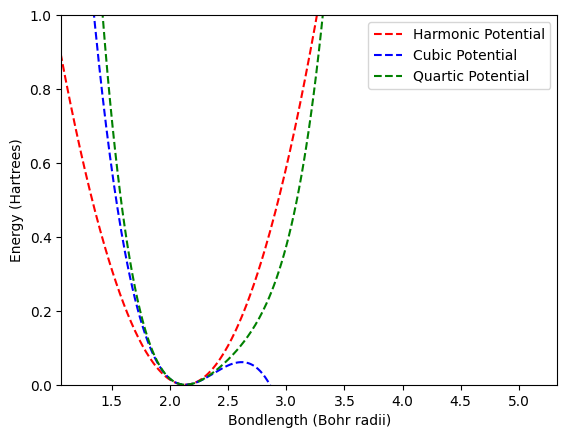

In [5]:
plt.plot(r, V_H, 'r--', label="Harmonic Potential")
plt.plot(r, V_H + V_C, 'b--', label="Cubic Potential")
plt.plot(r, V_H + V_C + V_Q, 'g--', label="Quartic Potential")
plt.xlim(0.5 * r_eq_au, 2.5 * r_eq_au)
plt.ylim(0, 1)
plt.xlabel("Bondlength (Bohr radii)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
plt.show()

# Compute the fundamental transition energies
Now we will compute the fundamental transition energies at all levels of theory and plot the results in both atomic units and in wavenumbers.